In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
purchase_prices = pd.read_csv('2017PurchasePricesDec.csv')
beginning_inventory = pd.read_csv('BegInvFINAL12312016.csv')
ending_inventory = pd.read_csv('EndInvFINAL12312016.csv')
invoice_purchases = pd.read_csv('InvoicePurchases12312016.csv')
purchases = pd.read_csv('PurchasesFINAL12312016.csv')
sales = pd.read_csv('SalesFINAL12312016.csv')

In [3]:
# Convert relevant columns to numeric
beginning_inventory['onHand'] = pd.to_numeric(beginning_inventory['onHand'], errors='coerce')
ending_inventory['onHand'] = pd.to_numeric(ending_inventory['onHand'], errors='coerce')
sales['SalesQuantity'] = pd.to_numeric(sales['SalesQuantity'], errors='coerce')
purchases['Quantity'] = pd.to_numeric(purchases['Quantity'], errors='coerce')

In [4]:
# Calculate total units sold during the year for each product
sales_summary = sales.groupby(['Brand', 'Description', 'Size']).agg({
    'SalesQuantity': 'sum',
    'SalesDollars': 'sum'
}).reset_index()

In [5]:
# Calculate the expected ending inventory
inventory_analysis = beginning_inventory.copy()
inventory_analysis = inventory_analysis.merge(
    purchases.groupby(['Brand', 'Description', 'Size'])['Quantity'].sum().reset_index(),
    on=['Brand', 'Description', 'Size'],
    how='left'
)
inventory_analysis = inventory_analysis.merge(
    sales_summary[['Brand', 'Description', 'Size', 'SalesQuantity']],
    on=['Brand', 'Description', 'Size'],
    how='left'
)
inventory_analysis = inventory_analysis.merge(
    ending_inventory[['Brand', 'Description', 'Size', 'onHand']],
    on=['Brand', 'Description', 'Size'],
    suffixes=('_start', '_end')
)

inventory_analysis['Expected_Ending'] = (
    inventory_analysis['onHand_start'] + inventory_analysis['Quantity'] - inventory_analysis['SalesQuantity']
)


In [6]:
# Identify overstocked and understocked items
inventory_analysis['Overstocked'] = inventory_analysis['onHand_end'] > inventory_analysis['Expected_Ending']
inventory_analysis['Understocked'] = inventory_analysis['onHand_end'] < inventory_analysis['Expected_Ending']

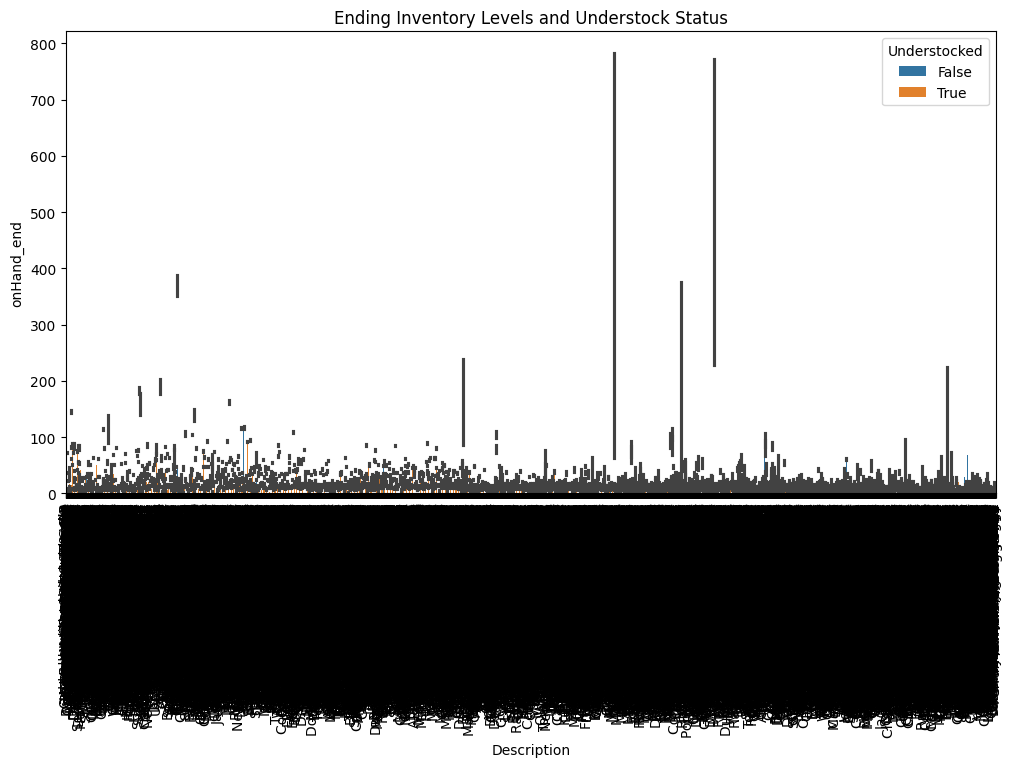

In [14]:
# Plot inventory levels
plt.figure(figsize=(12, 6))
sns.barplot(data=inventory_analysis, x='Description', y='onHand_end', hue='Understocked')
plt.xticks(rotation=90)
plt.title('Ending Inventory Levels and Understock Status')
plt.show()

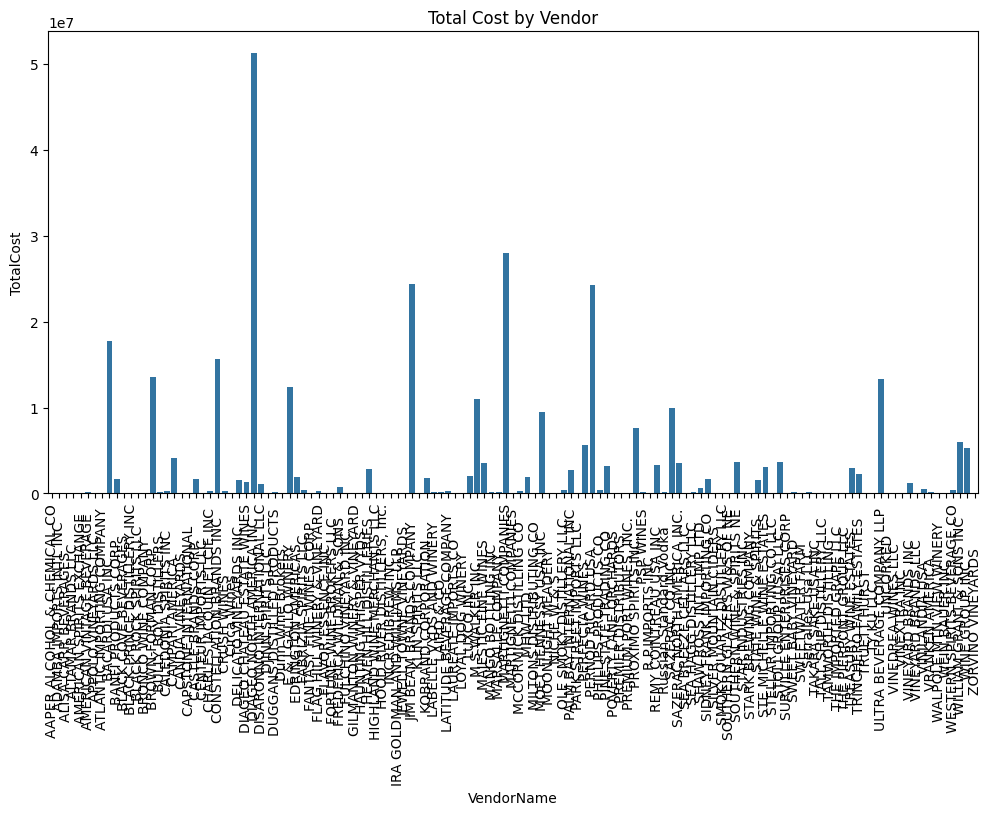

In [8]:
# Cost analysis of vendors
vendor_costs = invoice_purchases.groupby('VendorName').agg({
    'Dollars': 'sum',
    'Freight': 'sum'
}).reset_index()
vendor_costs['TotalCost'] = vendor_costs['Dollars'] + vendor_costs['Freight']

plt.figure(figsize=(12, 6))
sns.barplot(data=vendor_costs, x='VendorName', y='TotalCost')
plt.xticks(rotation=90)
plt.title('Total Cost by Vendor')
plt.show()

In [9]:
# Sales performance
sales_performance = sales_summary.copy()
sales_performance['SalesPrice'] = sales_performance['SalesDollars'] / sales_performance['SalesQuantity']


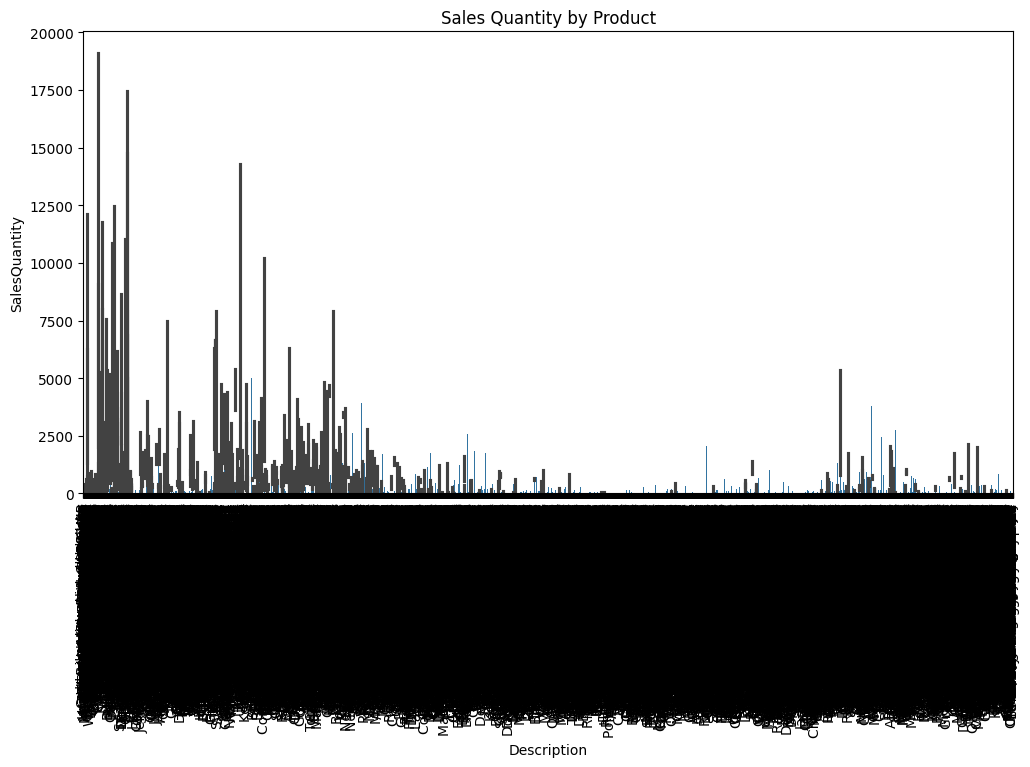

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_performance, x='Description', y='SalesQuantity')
plt.xticks(rotation=90)
plt.title('Sales Quantity by Product')
plt.show()

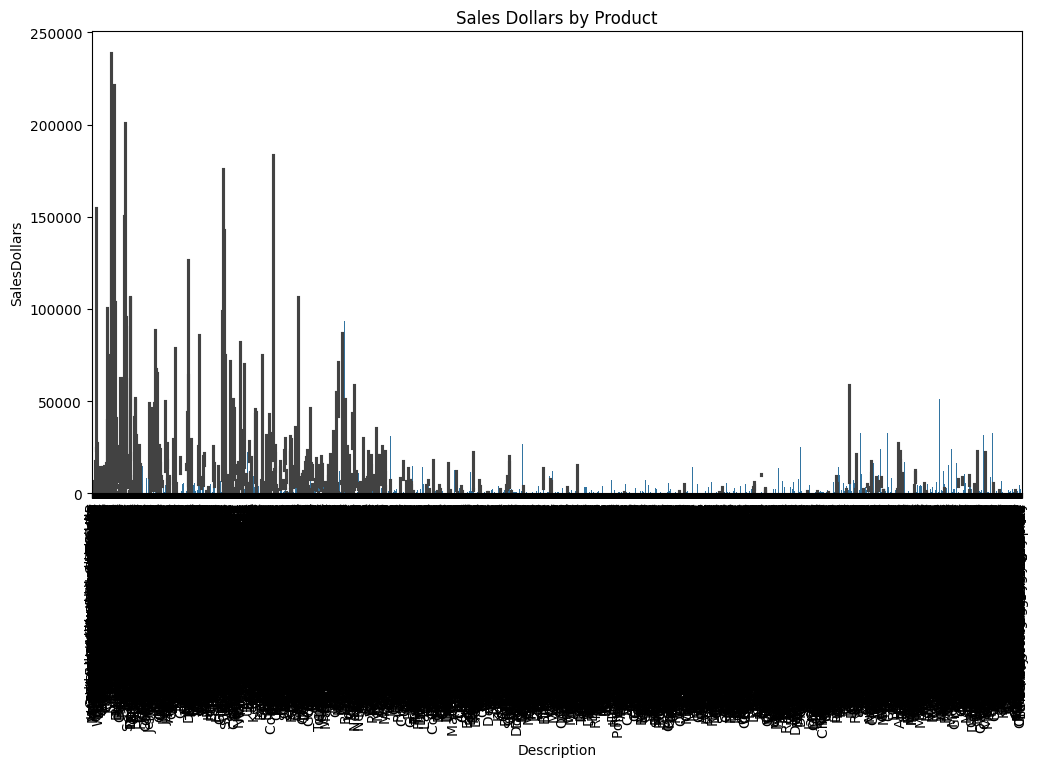

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_performance, x='Description', y='SalesDollars')
plt.xticks(rotation=90)
plt.title('Sales Dollars by Product')
plt.show()

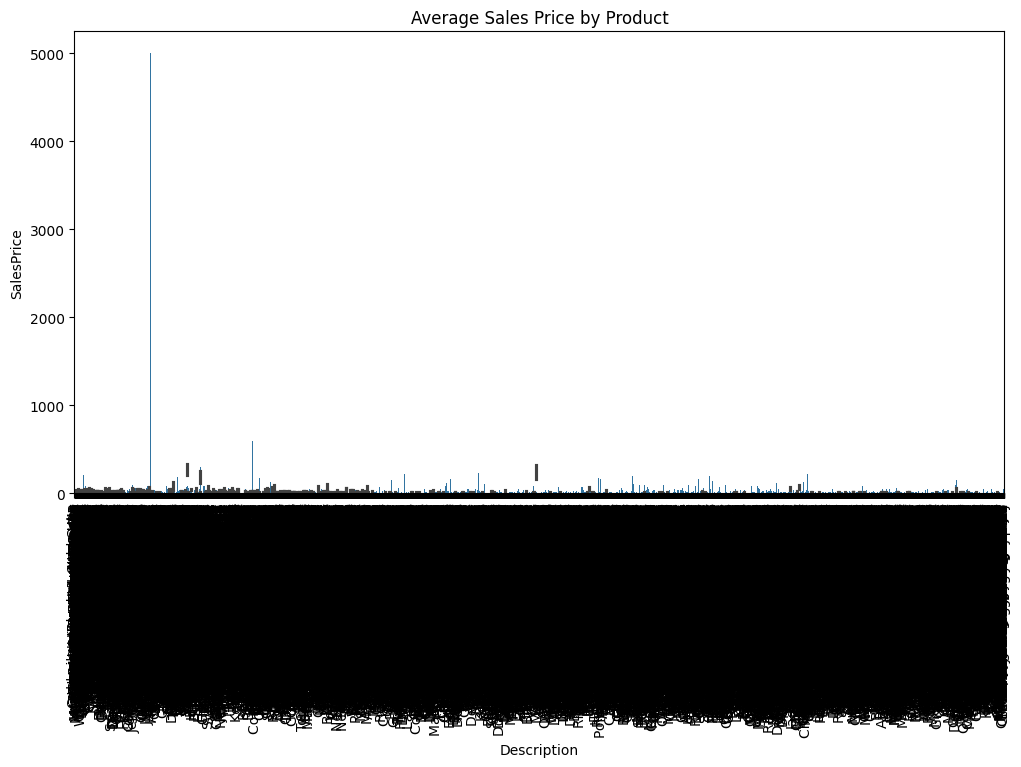

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_performance, x='Description', y='SalesPrice')
plt.xticks(rotation=90)
plt.title('Average Sales Price by Product')
plt.show()

In [15]:
inventory_analysis.to_csv('inventory_analysis_results.csv', index=False)
vendor_costs.to_csv('vendor_costs_analysis.csv', index=False)
sales_performance.to_csv('sales_performance_analysis.csv', index=False)